In [0]:
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/gdrive/My Drive/hot-dog-not-hot-dog"))

# Any results you write to the current directory are saved as output.

['seefood', 'train', 'test', 'checkpoints']


In [0]:
import time

import numpy as np
import torch
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from matplotlib import pyplot as plt

from tqdm import tqdm

from PIL import Image


def prepare_loader(train_dir, test_dir, transform_train, test_transforms,
                   batch_size=64, test_size=0.2, num_workers=0):
    """
    Helper function for prepare data loader
    :param train_dir: train data directory
    :param test_dir: test data directory
    :param transform_train: train transform
    :param test_transforms: test transform
    :param batch_size: batch size, default 64
    :param test_size: test split percentage, default 20%
    :param num_workers: num of worker, default 0
    :return: train loader and test loader
    """

    # data set
    train_data = datasets.ImageFolder(train_dir, transform=transform_train)
    test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

    # obtain training indices that will be used for validation
    num_train = len(train_data)

    # mix data
    # index of num of train
    indices = list(range(num_train))
    # random the index
    np.random.shuffle(indices)
    split = int(np.floor(test_size * num_train))
    # divied into two part
    train_idx, test_idx = indices[split:], indices[:split]

    # define the sampler
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # prepare loaders
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size,
        sampler=test_sampler, num_workers=num_workers)

    print("Train size:{}".format(num_train))
    print("Test size:{}".format(len(test_data)))

    return [train_loader, test_loader]


def load_latest_model(model, name="model.pt"):
    """
    Helper function for Load model
    :param model: current model
    :param name: model name
    :return: loaded model default model.pt
    """
    model.load_state_dict(torch.load(name))
    return model


def save_current_model(model, name='model.pt'):
    """
    Helper function for save model
    :param model: current model
    :param name: model name, default model.pt
    :return: None
    """
    torch.save(model.state_dict(), name)


def save_check_point(model, epoch, train_loader, classes, optimizer, scheduler=None,
                     path=None, name='model.pt'):
    """
    Helper function for save check point. save everything like epoch
    optimizer state and also model state
    :param model: current model
    :param epoch: total epoch
    :param train_loader: train data loader for extract class_to_idx
    :param classes: total classes in your datasets
    :param optimizer: optimizer
    :param scheduler: scheduler if any, default None
    :param path: path for saving model, default None
    :param name: model name, default model.pt
    :return: None
    """

    class_to_idx = train_loader.dataset.class_to_idx

    try:
        classifier = model.classifier
    except AttributeError:
        classifier = model.fc

    checkpoint = {
        'class_to_idx': class_to_idx,
        'class_to_name': classes,
        'epochs': epoch,
        'classifier': classifier,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    if scheduler is not None:
        checkpoint['scheduler_state_dict'] = scheduler.state_dict()

    if path is None:
        d = model
    else:
        d = path + "/" + name

    torch.save(checkpoint, d)
    print(f"Model saved at {d}")


def load_checkpoint(path, model, optimizer_name='adam', lr=0.003, momentum=None,
                    scheduler=None, step=2, gamma=0.1):
    """
    Helper function for load check point
    :param path: path of saved model
    :param model: current model
    :param optimizer_name: optimizer name, default Adam
    :param lr: learning rate, used to create optimizer
    :param momentum: momentum if you use SGD optimizer, default None
    :param scheduler: StepLR scheduler, if you want to create scheduler, default None
    :param step: Period of learning rate decay, default 2
    :param gamma: Multiplicative factor of learning rate decay. default: 0.1
    :return: model, optimizer and scheduler(if scheduler is not None)
    """

    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False

    # Load in checkpoint
    if torch.cuda.is_available():
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location="cpu")

    # Extract classifier
    classifier = checkpoint['classifier']
    # set classifier
    try:
        check = model.classifier
    except AttributeError:
        check = False

    if check is not False:
        model.classifier = classifier
    else:
        model.fc = classifier

    # Extract others
    model.cat_to_name = checkpoint['class_to_name']
    model.class_to_idx = checkpoint['class_to_idx']
    model.epochs = checkpoint['epochs']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        if momentum is not None:
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # load optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler is not None:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')
    print(f'Model has been trained for {model.epochs} epochs.')

    if scheduler is not None:
        return [model, optimizer, scheduler]
    else:
        return [model, optimizer]


def freeze_parameters(model):
    """
    Helper function for freeze parameter
    :param model: current model
    :return: new model with freeze parameters
    """
    for param in model.parameters():
        param.requires_grad = False

    return model


def unfreeze(model):
    """
    Helper function for unfreeze parameters
    :param model: current model
    :return: new model with unfreeze parameters
    """
    for param in model.parameters():
        param.requires_grad = True

    return model


def train(model, train_loader, test_loader,
          epochs, optimizer, criterion, scheduler=None,
          name="model.pt", path=None):
    """
    Helper function for train model
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler: scheduler, default None
    :param name: model name, default model.pt
    :param path: model saved location, default None
    :return: model, list of train loss and test loss
    """

    # compare overfitted
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        print("Epoch: {}/{}\n".format(epoch + 1, epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        if scheduler is not None:
            scheduler.step()  # step up scheduler

        for images, labels in tqdm(iterable=train_loader, total=len(train_loader)):
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)

        ######################
        # validate the model #
        ######################
        print("\n Going for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        print("Train loss:{:.6f}..".format(train_loss),
              "Valid Loss:{:.6f}..".format(valid_loss),
              "Accuracy: {:.4f}".format(correct / total * 100))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\n Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                torch.save(model.state_dict(), path)

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\nEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('\n Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # return the model
    return [model, train_loss_data, valid_loss_data]


def train_faster_log(model, train_loader, test_loader,
                     epochs, optimizer, criterion, scheduler=None, print_every=5):
    """
    Helper function for train model. This model print log after a certain interval
    in every epoch.
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler scheduler, default None
    :param print_every: print log interval
    :return:
    """

    steps = 0
    running_loss = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        test_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch + 1}/{epochs}.. "
                      f"Train loss: {running_loss / print_every:.3f}.. "
                      f"Test loss: {test_loss / len(test_loader):.3f}.. "
                      f"Test accuracy: {accuracy / len(test_loader):.3f}")
                running_loss = 0
                model.train()

    if scheduler is not None:
        scheduler.step()

    return model


def check_overfitted(train_loss, test_loss):
    """
    Helper function for check over fitting
    :param train_loss: list of train loss
    :param test_loss: list of test loss
    :return: None
    """
    plt.plot(train_loss, label="Training loss")
    plt.plot(test_loss, label="validation loss")
    plt.legend(frameon=False)


def test_per_class(model, test_loader, criterion, classes):
    """
    Helper function for testing per class
    :param model: current model
    :param test_loader: test loader
    :param criterion: loss function
    :param classes: list of classes
    :return: None
    """

    total_class = len(classes)

    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()  # prep model for evaluation

    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        
        for i in range(target.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))


def test(model, loader, criterion=None):
    """
    Helper function for test result. This function use torch.mean()
    :param model: current result
    :param loader: test data loader
    :param criterion: loss function to track loss, default None
    :return: None
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loss = 0
    accuracy = 0

    with torch.no_grad():
        model.eval()

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)

            if criterion is not None:
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    if criterion is not None:
        print("Test Loss:{:.6f}".format(test_loss),
              "\nAccuracy: {:.4f}".format(accuracy / len(loader) * 100))
    else:
        print("Accuracy: {:.4f}".format(accuracy / len(loader) * 100))

In [0]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image.T)
    plt.show()

def show(index, dataset, transforms=None):

    image = dataset[index][0]
    target = dataset[index][1]

    visualize(image=image)
    print('target is: ', target)

def show_random(dataset, transforms=None):
    length = len(dataset)
    index = random.randint(0, length - 1)
    show(index, dataset, transforms)

In [0]:
data_dir = "/content/gdrive/My Drive/hot-dog-not-hot-dog/seefood"

In [0]:
os.listdir(data_dir)

['train', 'test']

In [0]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                # albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                # albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [0]:
from torchvision import datasets


class HotDogDataset(datasets.ImageFolder):
    def __init__(self, img_dir, transform, augmentation):
        super().__init__(img_dir, transform=None)
        self.augmentation = augmentation
        self.prep = transform

    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        image = np.array(image)
        
        if self.augmentation:
            image = self.augmentation(image=image)['image']
            
        image = Image.fromarray(image)

        if self.prep:
            image = self.prep(image)
            # image = Image.fromarray(image.numpy())
        
        return image, target

In [0]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader


def get_loaders(data_dir, batch_size=64, train_augmentation=None, test_aumgentation=None, train_transform=None, test_transform=None):
    # train_dataset = datasets.ImageFolder(data_dir+"/train", transform=train_transform)
    train_dataset = HotDogDataset(data_dir+"/train", transform=train_transform, augmentation=train_augmentation)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

    # test_dataset = datasets.ImageFolder(data_dir+"/test", transform=test_transform)
    test_dataset = HotDogDataset(data_dir+"/test", transform=test_transform, augmentation=test_aumgentation)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    loaders = {}
    loaders['train'] = train_loader
    loaders['test'] = test_loader

    return loaders

In [0]:
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
from torchvision import models


def initialize_model(num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    
    """ Resnet18
    """
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

In [0]:
from torchvision import transforms

# torchvision.models documentation recomendation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.RandomResizedCrop(224),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])


loaders = get_loaders(
    data_dir,
    batch_size=batch_size,
    train_augmentation=get_training_augmentation(),
    test_aumgentation=None,
    train_transform=train_transform,
    test_transform=test_transform
)

train_loader, test_loader = loaders["train"], loaders["test"]

print(len(train_loader))
print(len(test_loader))

32
32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


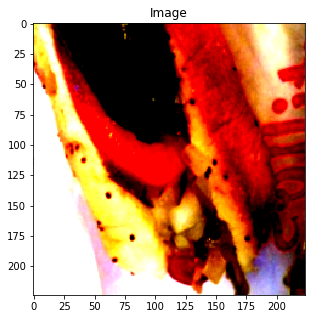

target is:  0


In [0]:
show_random(datasets.ImageFolder(data_dir+"/train", transform=train_transform))

In [0]:
classes = os.listdir(data_dir+"/train")
classes

['not_hot_dog', 'hot_dog']

Initialize model

In [0]:
model, input_size = initialize_model(num_classes=num_classes, feature_extract=feature_extract, use_pretrained=True)

In [0]:
import torch.optim as optim
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

criterion = torch.nn.NLLLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr=0.003)

In [0]:
epoch = 10

In [0]:
torch.cuda.empty_cache()

In [0]:
model, train_loss, test_loss = train(model, train_loader, test_loader, epoch, optimizer, criterion, path=None)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1/10



100%|██████████| 32/32 [00:09<00:00,  3.45it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.460730.. Valid Loss:0.322600.. Accuracy: 85.4902

 Validation loss decreased (inf --> 0.322600).  Saving model ...

Epoch:1 completed in 0m 14s
Epoch: 2/10



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.441730.. Valid Loss:0.394031.. Accuracy: 81.1765

Epoch:2 completed in 0m 13s
Epoch: 3/10



100%|██████████| 32/32 [00:09<00:00,  3.49it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.571710.. Valid Loss:0.293284.. Accuracy: 86.8627

 Validation loss decreased (0.322600 --> 0.293284).  Saving model ...

Epoch:3 completed in 0m 14s
Epoch: 4/10



100%|██████████| 32/32 [00:09<00:00,  3.53it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.423149.. Valid Loss:0.316783.. Accuracy: 86.6667

Epoch:4 completed in 0m 13s
Epoch: 5/10



100%|██████████| 32/32 [00:09<00:00,  3.45it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.437440.. Valid Loss:0.310955.. Accuracy: 86.2745

Epoch:5 completed in 0m 14s
Epoch: 6/10



100%|██████████| 32/32 [00:09<00:00,  3.49it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.406453.. Valid Loss:0.289434.. Accuracy: 88.4314

 Validation loss decreased (0.293284 --> 0.289434).  Saving model ...

Epoch:6 completed in 0m 14s
Epoch: 7/10



100%|██████████| 32/32 [00:09<00:00,  3.49it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.403039.. Valid Loss:0.283831.. Accuracy: 89.0196

 Validation loss decreased (0.289434 --> 0.283831).  Saving model ...

Epoch:7 completed in 0m 14s
Epoch: 8/10



100%|██████████| 32/32 [00:08<00:00,  3.57it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.428202.. Valid Loss:0.332564.. Accuracy: 86.0784

Epoch:8 completed in 0m 13s
Epoch: 9/10



100%|██████████| 32/32 [00:08<00:00,  3.57it/s]



 Going for validation


  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.407987.. Valid Loss:0.288522.. Accuracy: 88.4314

Epoch:9 completed in 0m 13s
Epoch: 10/10



100%|██████████| 32/32 [00:09<00:00,  3.51it/s]



 Going for validation
Train loss:0.448889.. Valid Loss:0.403567.. Accuracy: 83.1373

Epoch:10 completed in 0m 13s

 Training completed in 2m 15s


In [0]:
model = load_latest_model(model)

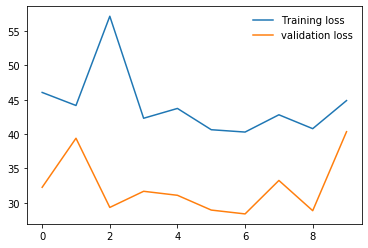

In [0]:
check_overfitted(train_loss, test_loss)

In [0]:
test(model, test_loader)

Accuracy: 89.0346


In [0]:
test_per_class(model, test_loader, criterion, classes)

Test Loss: 0.283831

Test Accuracy of     0: 85% (221/260)
Test Accuracy of     1: 93% (233/250)

 Test Accuracy (Overall): 89% (454/510)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


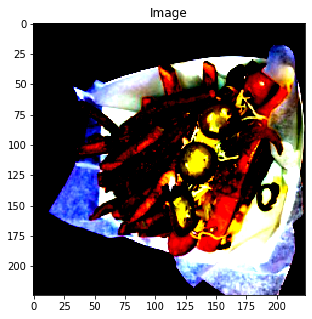

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


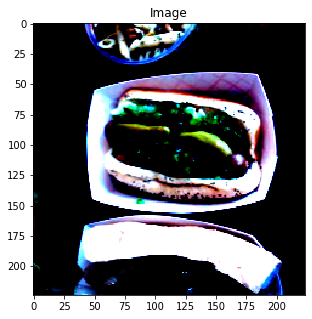

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


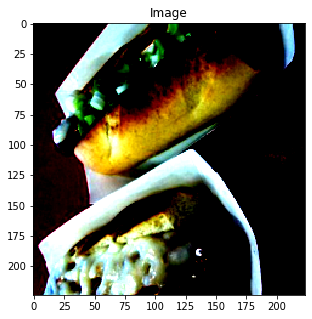

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


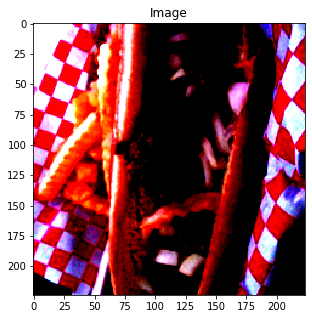

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


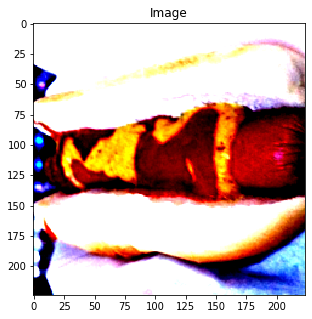

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


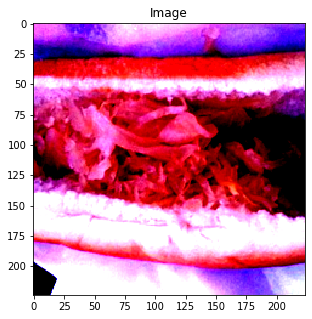

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


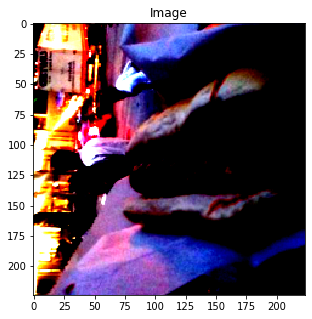

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


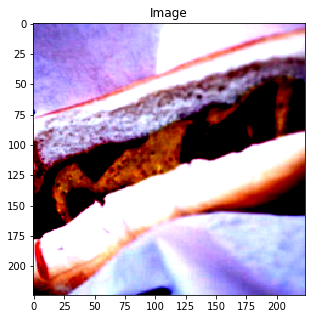

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


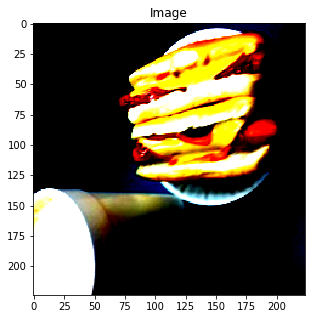

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label:  0
predicted label:  0


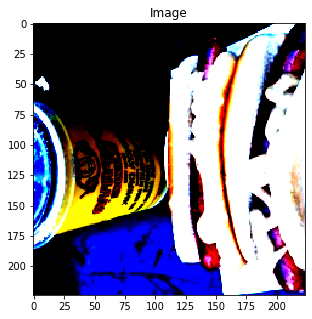

true label:  0
predicted label:  1


In [0]:
max_count = 9

infer_dataset = HotDogDataset(data_dir+"/test", transform=test_transform, augmentation=None)


for i, (image, label) in enumerate(infer_dataset):
    image.to(device)
    image = [image.numpy()]*32
    image = np.array(image)
    image = torch.Tensor(image)
    predict = model(image.to(device))
    
    visualize(image=image[0,:,:,:])
    print('true label: ', label)
    print('predicted label: ', np.argmax(predict[0].cpu().detach().numpy()))
    
    if i >= max_count:
        break